In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1 生成数据并显示

In [3]:
path = "F:\OneDrive\AI资料\机器学习\浩杰给的课件\pytorch\实验数据\车辆分类数据集"
classes = ('bus', 'car', 'truck')
num_classes = 3

def readImagesToNumpy(path):
    x = []
    for filename in os.listdir(path):
        #print(filename)
        if filename[-3:len(filename)] not in ['jpg', 'png']:
            continue
        file = path + '\\' + filename
        img = Image.open(file)
        img = img.resize((150, 200), Image.ANTIALIAS) #read the image
        img = np.transpose(img, (2, 0, 1))
        img = np.array(img) # transform to numpy
        img = img / 255 # normalize
        #plt.imshow(img)
        #plt.show()
        #print(img.shape)
        x.append(img)
        #break
    return np.array(x)

def getTheTrainAndTestSet(path, classes):
    x_trainset, y_trainset = [], []
    x_testset, y_testset = [], []
    for i in range(len(classes)):
        x = readImagesToNumpy(path + '\\' + classes[i])
        y = np.zeros(len(x)); y[:] = i

        train_num = len(x)*4//5
        x_train = x[:train_num, :]
        y_train = y[:train_num]
        x_test = x[train_num:, :]
        y_test = y[train_num:]
        
        x_trainset.extend(x_train)
        y_trainset.extend(y_train)
        x_testset.extend(x_test)
        y_testset.extend(y_test)
    return x_trainset, y_trainset, x_testset, y_testset

X_train, y_train, X_test, y_test = getTheTrainAndTestSet(path, classes)

In [4]:
X_train = torch.tensor(np.array(X_train))
y_train = torch.tensor(np.array(y_train))
X_test = torch.tensor(np.array(X_test))
y_test = torch.tensor(np.array(y_test))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train[0, :], y_train[0])

torch.Size([1085, 3, 200, 150]) torch.Size([1085]) torch.Size([272, 3, 200, 150]) torch.Size([272])
tensor([[[0.5961, 0.5843, 0.5725,  ..., 0.4235, 0.3961, 0.3843],
         [0.5922, 0.5804, 0.5608,  ..., 0.4667, 0.4431, 0.4314],
         [0.5843, 0.5725, 0.5451,  ..., 0.5255, 0.5098, 0.5020],
         ...,
         [0.6588, 0.6549, 0.6471,  ..., 0.2196, 0.2078, 0.2039],
         [0.6588, 0.6549, 0.6471,  ..., 0.2314, 0.2157, 0.2118],
         [0.6588, 0.6549, 0.6471,  ..., 0.2353, 0.2235, 0.2196]],

        [[0.7137, 0.7020, 0.6902,  ..., 0.5176, 0.4941, 0.4824],
         [0.7098, 0.6980, 0.6784,  ..., 0.5608, 0.5412, 0.5294],
         [0.7020, 0.6902, 0.6627,  ..., 0.6157, 0.6078, 0.6000],
         ...,
         [0.6353, 0.6314, 0.6196,  ..., 0.3294, 0.3176, 0.3137],
         [0.6353, 0.6314, 0.6196,  ..., 0.3333, 0.3216, 0.3176],
         [0.6353, 0.6314, 0.6196,  ..., 0.3373, 0.3255, 0.3216]],

        [[0.7569, 0.7451, 0.7333,  ..., 0.6314, 0.6078, 0.6000],
         [0.7529, 0.741

## 2 读取数据

In [5]:
def get_labels(labels):
    text_labels = ['bus', 'car', 'truck']
    return [text_labels[int(i)] for i in labels]

def show_images(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(6, 6))
    for f, img, lbl in zip(figs, images, labels):
        img = np.transpose(img, (1, 2, 0))
        f.imshow(img)
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

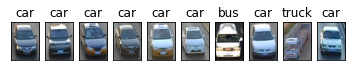

In [6]:
batch_size = 10
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for X, y in train_loader:
    show_images(X[:10, :], get_labels(y[:10]))
    break

## 3 定义卷积层和模型

In [7]:
class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(10, num_classes)
    
    def forward(self, X):
        # 三层卷积
        out = self.conv(X)
        # 128层每一层取平均，batch*128*1*1
        out = F.avg_pool2d(out, (198, 148))
        # 变为batch*128
        out = out.squeeze()
        # 全连接
        out = self.fc(out)
        return out

## 4 定义模型参数

In [8]:
epochs = 50
lr = 0.001

net = ConvModule().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=lr)

## 5 训练模型

In [9]:
def train_epoch(net, data_loader, device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).long()

        optimizer.zero_grad()
        output = net(data)
        if len(data) == 1: output = output.view(1, len(output))
        #print(output.shape, target.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        prediction = torch.argmax(output, dim=1)
        correct += (prediction == target).sum().item()
        sample_num += len(data)
    
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()

            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, dim=1)
            correct += (prediction == target).sum().item()
            sample_num += len(data)
        
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [10]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

torch.cuda.empty_cache()

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(net, train_loader, device)
    test_loss, test_acc = test_epoch(net, test_loader, device)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    print('epoch %d, train loss %.4lf, train acc %.4lf, test loss %.4lf, test acc %.4lf' % (epoch + 1, train_loss, train_acc, test_loss, test_acc))

epoch 1, train loss 1.0606, train acc 0.3945, test loss 1.3579, test acc 0.1912
epoch 2, train loss 0.8603, train acc 0.6903, test loss 1.2884, test acc 0.2316
epoch 3, train loss 0.8058, train acc 0.6876, test loss 1.2862, test acc 0.1838
epoch 4, train loss 0.7674, train acc 0.6977, test loss 1.3100, test acc 0.2426
epoch 5, train loss 0.7495, train acc 0.7207, test loss 1.3080, test acc 0.2279
epoch 6, train loss 0.7157, train acc 0.7336, test loss 1.5896, test acc 0.2022
epoch 7, train loss 0.7141, train acc 0.7327, test loss 1.6067, test acc 0.2647
epoch 8, train loss 0.6992, train acc 0.7401, test loss 1.6835, test acc 0.1544
epoch 9, train loss 0.6885, train acc 0.7530, test loss 1.9352, test acc 0.2574
epoch 10, train loss 0.6614, train acc 0.7742, test loss 1.4587, test acc 0.2684
epoch 11, train loss 0.6843, train acc 0.7641, test loss 1.8907, test acc 0.2096
epoch 12, train loss 0.6661, train acc 0.7668, test loss 2.1005, test acc 0.2132
epoch 13, train loss 0.6477, train ac